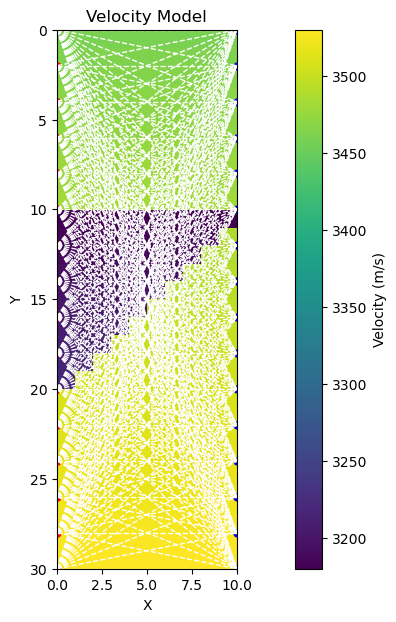

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the new 3x5 velocity model


rows, cols = 30, 10
grid_size = (rows, cols)
min_velocity = 3460
max_velocity = 3530
wedge_min_velocity = 3180
wedge_max_velocity = 3220
wedge_start_row = 10
wedge_end_row = 20

# Create a background velocity model with values ranging from 3460 to 3530
velocity_model = np.linspace(min_velocity, max_velocity, rows).reshape(-1, 1)
velocity_model = np.repeat(velocity_model, cols, axis=1)

# Create a triangular wedge shape with vertices at (0, 10), (0, 20), and (10, 10)
for i in range(wedge_start_row, wedge_end_row):
    row_velocity = np.linspace(wedge_min_velocity, wedge_max_velocity, wedge_end_row - wedge_start_row)[i - wedge_start_row]
    num_cols_in_wedge = wedge_end_row - i
    velocity_model[i, :num_cols_in_wedge] = row_velocity


# Functions
def plot_velocity_model_with_sources_and_receivers(velocity_model, sources, receivers, cols, rows, showlines):
    plt.figure(figsize=(15, 7))  
    plt.imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper')
    plt.colorbar(label='Velocity (m/s)')
    plt.title('Velocity Model')
    plt.xlabel('X')
    plt.ylabel('Y')

    # # Add numbers to the grid
    # rows, cols = velocity_model.shape
    # for i in range(rows):
    #     for j in range(cols):
    #         plt.text(j + 0.5, i + 0.5, str(i * cols + j + 1), color='white', 
    #                  ha='center', va='center', fontsize=12, weight='bold')

    # # Plot the sources as stars with blue circles
    # for idx, source in enumerate(sources):
    #     plt.plot(source[0], source[1], marker='*', color='yellow', markersize=15)
    #     plt.text(source[0], source[1], f'{idx + 1}', color='blue', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='blue', boxstyle='circle'))

    # # Plot the receivers as dots
    # for idx, receiver in enumerate(receivers):
    #     plt.plot(receiver[0], receiver[1], marker='o', color='blue', markersize=10)
    #     plt.text(receiver[0], receiver[1], str(idx + 1), color='red', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='circle'))

    # # Plot lines between sources and receivers
    # for source in sources:
    #     for receiver in receivers:
    #         plt.plot([source[0], receiver[0]], [source[1], receiver[1]], color='white', linestyle='--', linewidth=1)
    
    # Plot the sources and receivers
    for idx, source in enumerate(sources):
        plt.plot(source[0], source[1], marker='o', color='red', markersize=5)

    for idx, receiver in enumerate(receivers):
        plt.plot(receiver[0], receiver[1], marker='o', color='blue', markersize=5)

    # Plot lines between sources and receivers
    if showlines == True:
        for source in sources:
            for receiver in receivers:
                plt.plot([source[0], receiver[0]], [source[1], receiver[1]], color='white', linestyle='--', linewidth=1)
    # plt.savefig('1.png')
    # plt.show()

def find_intersections(sources, receivers, grid_size):
    all_intersections = []
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            x0, y0 = source
            x1, y1 = receiver
            dx = x1 - x0
            dy = y1 - y0

            for j in range(grid_size[0]):  # rows
                for k in range(grid_size[1]):  # columns
                    # Calculate intersections with grid lines
                    cell_x_min = k
                    cell_x_max = k + 1
                    cell_y_min = j
                    cell_y_max = j + 1
                    intersections = []

                    # Left boundary
                    if dx != 0:
                        t = (cell_x_min - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_min, y))

                    # Right boundary
                    if dx != 0:
                        t = (cell_x_max - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_max, y))

                    # Bottom boundary
                    if dy != 0:
                        t = (cell_y_min - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_min))

                    # Top boundary
                    if dy != 0:
                        t = (cell_y_max - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_max))

                    # Add entry and exit points
                    if (cell_x_min <= x0 <= cell_x_max) and (cell_y_min <= y0 <= cell_y_max):
                        intersections.append((x0, y0))
                    if (cell_x_min <= x1 <= cell_x_max) and (cell_y_min <= y1 <= cell_y_max):
                        intersections.append((x1, y1))

                    # Remove duplicate points
                    intersections = list(set(intersections))
                    # Sort intersections by distance from the source
                    intersections = sorted(intersections, key=lambda p: np.hypot(p[0] - x0, p[1] - y0))

                    # Add intersections to all_intersections
                    all_intersections.append(intersections)

    return all_intersections

# Remove duplicates from intersections
def remove_duplicate_intersections(intersections):
    seen = set()
    unique_intersections = []

    for point_pair in intersections:
        if tuple(point_pair) not in seen:
            unique_intersections.append(point_pair)
            seen.add(tuple(point_pair))
        else:
            unique_intersections.append([])

    return unique_intersections

# Calculate distances from unique intersections and store them in a NumPy array
def calculate_distances(unique_intersections, grid_size, sources, receivers):
    distances = np.zeros((grid_size[0], grid_size[1], len(receivers), len(sources)))
    idx = -1
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            for j in range(grid_size[0]):
                for k in range(grid_size[1]):
                    idx = idx + 1
                    intersections = unique_intersections[idx]
                    if len(intersections) >= 2:
                        total_distance = 0
                        for idxx in range(len(intersections) - 1):
                            d = np.hypot(intersections[idxx + 1][0] - intersections[idxx][0], intersections[idxx + 1][1] - intersections[idxx][1])
                            total_distance += d
                        distances[j, k, i, s_idx] = total_distance
                    else:
                        distances[j, k, i, s_idx] = 0
    return distances

# Define sources and receivers
# sources = [(0, 1), (0, 2)]
# receivers = [(10, 1), (10, 2.5)]

sources = [(0, i * 2) for i in range(16)]
receivers = [(10, i * 2) for i in range(16)]


intersections = find_intersections(sources, receivers, grid_size=grid_size)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size, sources=sources, receivers=receivers)

plot_velocity_model_with_sources_and_receivers(velocity_model, sources, receivers, cols, rows, showlines=True)
# # Print the distances for each receiver from each source.
# for s_idx, source in enumerate(sources):
#     for i, receiver in enumerate(receivers):
#         print(f"Receiver {i+1} at {receiver} from Source {s_idx+1} at {source}:")
#         print(distances[:, :, i, s_idx])

30

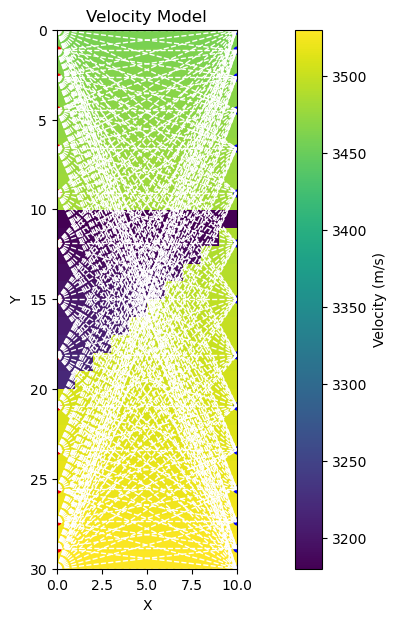

In [104]:
def device_location(n,rows):
    n2 = int(np.ceil(n/2))
    rows2 = rows/2
    x = np.array([x for x in range(n2)])
    y = np.array([(i+3)**2 for i in x])
    z = (y - y[0]) * rows2 / (y[-1] - y[0])
    z_reversed_steps = rows2 + (rows2 - z[::-1])
    z_combined = np.concatenate((z, z_reversed_steps[1:]))
    return z_combined
z = device_location(n=15, rows=rows)

# Define sources and receivers
sources = [(0, i) for i in z]
receivers = [(10, i) for i in z]

intersections = find_intersections(sources, receivers, grid_size=grid_size)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size, sources=sources, receivers=receivers)

plot_velocity_model_with_sources_and_receivers(velocity_model, sources, receivers, cols, rows, showlines=True)
# # Print the distances for each receiver from each source.
# for s_idx, source in enumerate(sources):
#     for i, receiver in enumerate(receivers):
#         print(f"Receiver {i+1} at {receiver} from Source {s_idx+1} at {source}:")
#         print(distances[:, :, i, s_idx])
rows

In [142]:
D = []
T = []
s1 = 1/velocity_model

nreceiver = len(receivers)
nsource = len(sources)

for i in range(nsource):
    for j in range(nreceiver):
        D.append(distances[:,:,j,i].flatten())
        T.append(sum(sum(distances[:,:,j,i]*s1)))    
D = np.array(D)
Df = pd.DataFrame(D)
s1 = s1.flatten()
Df;

### Testing

In [143]:
s, residuals, rank, s_val = np.linalg.lstsq(D, T, rcond=None)
v_inversion = s**-1
v_inversion.reshape(rows,cols)
np.max(abs(s-s1.flatten()))

6.948980392180689e-06

In [144]:
np.max(abs(D@(s1.flatten())-D@s))

5.421010862427522e-17

### Quantum annealing

In [145]:
import numpy as np
from dwave.system import DWaveSampler, EmbeddingComposite
"""
Dwave sampler is an object that represents the quantum annealer itself. It is responsible for directly interacting with the quantum hardware.
When you create an instance of DWaveSampler, you are preparing to submit your optimization problem to a D-Wave quantum annealer for solution.

EmbeddingComposite is a wrapper around samplers that automatically handles the problem of embedding. Embedding is the process of mapping your
problem from its logical representation to the physical representation.

"""

def dict_to_vector_auto(q_dict):
    """
    Convert a solution dictionary from a QUBO problem into a vector representation.
    
    Args:
        q_dict (dict): The solution dictionary where keys are variable indices and values are the binary values.
    
    Returns:
        np.ndarray: The vector representation of the solution.
    """
    # Determine the size of the vector (n) based on the highest index in q_dict
    n = max(q_dict.keys()) + 1
    
    # Initialize a vector of size n with zeros
    q_vector = np.zeros(n, dtype=int)
    
    # Populate the vector with the values from the solution dictionary
    for i, value in q_dict.items():
        q_vector[i] = value
    
    return q_vector
def qubo_to_matrix_auto(Q):
    """
    Convert a QUBO problem defined by a dictionary into a matrix representation,
    automatically determining the matrix size.
    
    Args:
        Q (dict): The QUBO problem coefficients, where keys are tuples representing interactions between variables,
                  and values are the weights of these interactions.
    
    Returns:
        np.ndarray: The matrix representation of the QUBO problem.
    """
    # Determine the size of the matrix (n) based on the highest index in Q
    n = max(max(pair) for pair in Q.keys()) + 1
    
    # Initialize an nxn matrix with zeros
    Q_matrix = np.zeros((n, n))
    
    # Populate the matrix with the values from the QUBO dictionary
    for (i, j), value in Q.items():
        Q_matrix[i, j] = value
        if i != j:  # Ensure the matrix is symmetric
            Q_matrix[j, i] = value
    
    return Q_matrix
def binary_least_squares_qubo(A, b):
    """
    Transforms the binary least squares problem into a QUBO problem.
    Args:
        A (np.ndarray): The matrix A in the binary least squares problem.
        b (np.ndarray): The vector b in the binary least squares problem.
    Returns:
        dict: The QUBO coefficients.
    """
    # Number of variables
    n = A.shape[1]

    # Compute A^T * A and A^T * b
    ATA = A.T @ A
    ATb = A.T @ b

    # Initialize the QUBO dictionary
    Q = {}

    # Fill the QUBO coefficients
    for i in range(n):
        for j in range(i, n):
            if i == j:  # Diagonal entries
                Q[(i, i)] = ATA[i, i] - 2 * ATb[i]
            else:  # Off-diagonal entries
                Q[(i, j)] = 2 * ATA[i, j]

    return Q
def calculate_objective_value(A, b, q):
    """
    Calculates the objective value ||Aq - b||^2 for a given binary vector q.

    Args:
        A (np.ndarray): The matrix A.
        b (np.ndarray): The vector b.
        q (np.ndarray): The binary vector q for which to calculate the objective value.

    Returns:
        float: The calculated objective value.
    """
    # Ensure q is a numpy array for matrix operations
    q = np.array(q)
    
    # Calculate the difference between Aq and b
    diff = np.dot(A, q) - b
    
    # Calculate the objective value as the square of the L2 norm of the difference
    objective_value = np.dot(diff, diff)
    
    return objective_value

# Define or generate your A (10x10) and b (10-dimensional)
np.random.seed(999)  # For reproducible random results
sizematrix = 18
A = np.random.randint(1, 10, size=(sizematrix, sizematrix-2))
b = np.random.randint(1, 10, size=(sizematrix,))


# Convert the binary least squares problem to QUBO
Q = binary_least_squares_qubo(A, b)

# Solve the QUBO using D-Wave's system
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads=100)
"""
The num_reads refers to the number of times the QA process is repeated.
The QAM is a probabilistic method, meaning that it may not find the absolute best solution on every run
due to its reliance on quantum fluctuations and thermal dynamics.
Therefore by increasing the num_read, we increase the chances of finding the global minimum of the problem's energy landscape.
High num_reads: increases the probability of finding the optimal solution but requres more times and resources.
Low num_reads: faster and uses fewer resources but might miss the optimal solution.
So far, what all we need is the QUBO Matrix.
"""
# Print the best sample
q = dict_to_vector_auto(sampleset.first.sample)

print("A:")
print(A)
print("\nb:", b)
print("\nBest binary vector q:", q)
print("Minimum objective value:", calculate_objective_value(A,b,q))

A:
[[1 6 2 9 2 4 1 6 9 9 1 6 3 6 8 5]
 [7 3 8 7 2 6 4 7 5 1 5 5 9 8 3 8]
 [5 5 6 2 7 9 2 2 2 7 4 4 9 1 2 5]
 [1 7 5 8 4 5 8 5 7 5 8 4 1 5 5 7]
 [9 7 1 5 7 8 1 2 3 6 8 3 2 3 4 4]
 [3 4 4 5 2 7 6 2 3 3 4 9 1 1 6 1]
 [8 1 6 3 9 5 7 9 5 8 6 3 6 9 4 4]
 [7 9 5 1 6 8 9 5 6 1 1 1 4 6 2 6]
 [5 7 2 7 3 9 3 6 5 2 5 3 4 4 6 4]
 [4 2 7 4 5 7 7 4 3 3 7 6 1 7 6 1]
 [2 1 2 9 4 5 8 8 2 9 8 8 3 3 2 3]
 [5 3 1 4 5 4 6 7 7 4 7 2 5 1 2 9]
 [3 8 5 4 8 7 6 1 6 3 5 1 3 7 8 1]
 [1 3 5 2 7 3 1 1 2 5 8 2 1 7 7 5]
 [7 7 6 3 8 1 8 6 5 1 2 6 6 2 2 9]
 [6 7 3 9 7 1 8 2 4 1 3 3 2 1 3 6]
 [1 1 8 1 3 1 4 4 8 1 8 4 6 3 5 3]
 [4 3 9 6 7 1 6 9 1 1 8 5 9 4 9 7]]

b: [4 3 8 4 6 1 4 2 7 1 6 7 6 2 5 2 3 9]

Best binary vector q: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Minimum objective value: 113


In [14]:
import numpy as np
from itertools import product
from tqdm import tqdm

# Define A and b

# Function to calculate objective function value
def calculate_objective(A, b, p):
    diff = np.dot(A, p) - b
    return np.dot(diff, diff)

def calculate_residuals(A, x, b):
    """
    Calculate the squared norm of the residuals ||Ax - b||^2.
    
    Args:
        A (np.ndarray): The matrix A in the least squares problem.
        x (np.ndarray): The vector x in the least squares problem.
        b (np.ndarray): The vector b in the least squares problem.
    
    Returns:
        float: The squared norm of the residuals.
    """
    residuals = A @ x - b
    return np.sum(residuals ** 2)


# Initialize variables to track the best solution
min_value = float('inf')
best_p = None

# Prepare all combinations of p for tqdm
total_combinations = list(product([0, 1], repeat=A.shape[1]))

# Iterate over all possible combinations of p with tqdm progress bar
for p_combination in tqdm(total_combinations, desc="Evaluating combinations", colour='green'):
    p = np.array(p_combination)
    value = calculate_objective(A, b, p)
    if value < min_value:
        min_value = value
        best_p = p

print("Best binary vector p:", best_p)
print("Minimum objective value:", min_value)

Evaluating combinations: 100%|██████████| 65536/65536 [00:00<00:00, 163849.43it/s]


Best binary vector p: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Minimum objective value: 113


In [16]:
import numpy as np

def real2binary(x, n_bits, j0):
    """
    Discretize a real-valued vector x using b-bit fixed point approximation.
    
    Args:
    x (np.ndarray): The real-valued vector to be discretized.
    b (int): The number of bits for the fixed point binary representation.
    j0 (int): The position of the fixed point, with 0 being the least significant bit.
    
    Returns:
    np.ndarray: The binary vector representing the discretized version of x.
    """
    # Scale x by 2^(b-j0) to move the fixed point
    scaled_x = x * (2 ** (n_bits - j0))
    # Round the scaled values to the nearest integer
    int_x = np.rint(scaled_x).astype(int)
    # Ensure the integer values are within the allowed range for the b-bit representation
    max_int = 2 ** n_bits - 1
    int_x_clipped = np.clip(int_x, 0, max_int)
    # Convert the integer values to binary strings, remove the '0b' prefix, and zero-pad to b bits
    binary_x = [format(val, f'0{n_bits}b') for val in int_x_clipped]
    # Flatten the binary strings into a single binary vector
    binary_vector = np.array([int(bit) for bin_str in binary_x for bit in bin_str])
    
    return binary_vector

def binary2real(binary_vector, n_bits, j0):
    """
    Convert a binary vector to a real number using n-bit fixed point representation.

    Args:
        binary_vector (np.ndarray): The binary vector to be converted.
        n_bits (int): The number of bits used for the fixed point representation.
        j0 (int): The position of the fixed point.

    Returns:
        np.ndarray: The real number representation of the binary vector.
    """
    # Determine the number of elements in the real number vector

    num_elements = len(binary_vector) // n_bits
    
    # Initialize the real number vector
    real_vector = np.zeros(num_elements)
    
    # Extract the real number from the binary representation
    for i in range(num_elements):
        # Extract the binary representation of the current real number
        binary_repr = binary_vector[i * n_bits:(i + 1) * n_bits]
        
        # Convert binary to integer, taking into account the fixed point position
        int_value = 0
        for bit_pos, bit in enumerate(reversed(binary_repr)):
            int_value += bit * (2 ** (bit_pos - j0))
        
        # Add the integer value to the real number vector
        real_vector[i] = int_value
    
    return real_vector



# Example usage
# Real-valued vector x
x_test = np.array([1541.93])

n_bits = 22
j0 = 12  

# Discretize the vector x
q_binary_vector = real2binary(x_test, n_bits, j0)
print("q_binary_vector:", q_binary_vector)

# Recompute
approximated_value = binary2real(q_binary_vector, n_bits, n_bits-j0)
print("approximated_value:", approximated_value)
print("The difference:", abs(approximated_value- x_test))

q_binary_vector: [0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0]
approximated_value: [1541.9296875]
The difference: [0.0003125]


In [17]:
import numpy as np

# Function to construct the Ad matrix given A and n
def construct_Ad(A, n, j0):
    N, M = A.shape  # Number of rows and original number of columns in A
    Ad = np.zeros((N, M * n))  # Initialize Ad with the correct shape
    
    for i in range(M):
        for j in range(n):
            # Construct the columns of Ad based on A and the bit significance
            Ad[:, i * n + j] = A[:, i] * (2 ** (j0 - j))
    
    # The original code which follows the paper should return Ad.
    # However, after multiple tries, I come up with return Ad/2.
    return Ad/2

In [18]:
# Example matrix A (Let's create a 3x3 matrix for this example)
A = np.array([[1, 1.25,1.75], 
              [1.75, 1.5, 1],
              [1.75, 1.5, 1.25]])

# Number of bits for discretization
n = 3

# j0 sets the fixed point
j0 = 1

# Construct the Ad matrix
Ad = construct_Ad(A, n, j0)

In [19]:
M = D.copy()
I = np.ones(M.shape[1])  # Assuming M is a 2D numpy array
R = 3
t = T


-1.6063829787234122e-06
1.502672010688104e-06


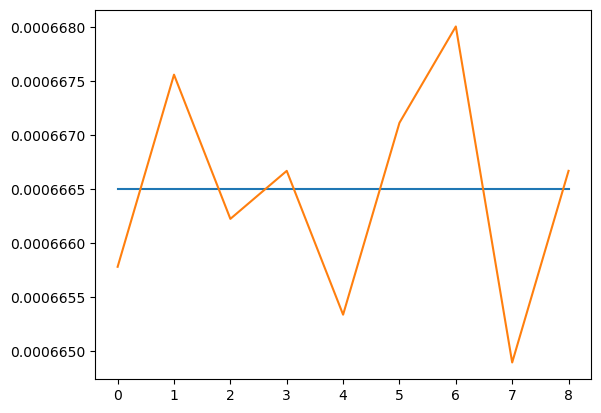

In [29]:
s0 = np.ones(s.shape)*0.0006665

plt.plot(s0)
plt.plot(s1)


print(min(s1-s0))
print(max(s1-s0))

Evaluating combinations: 100%|██████████| 10/10 [00:41<00:00,  4.10s/it]


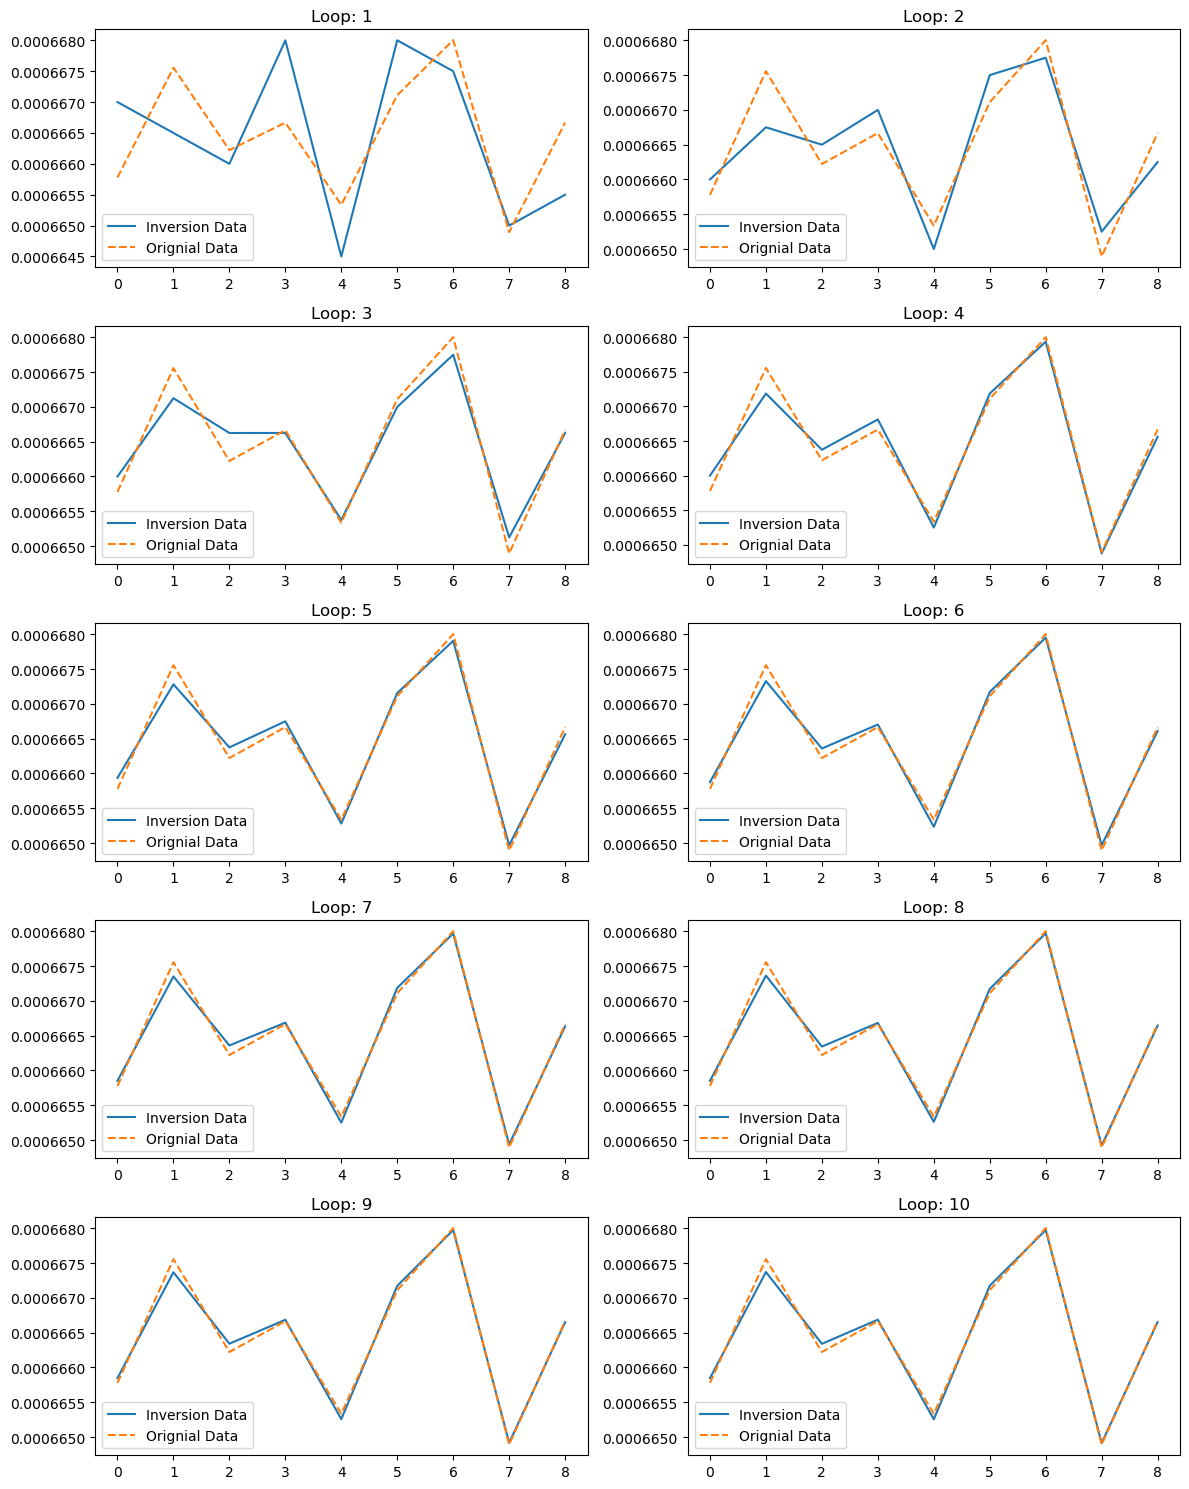

In [30]:
s0 = np.ones(s.shape)*0.0006665

A = construct_Ad(M, R, 1)
L = 2e-6

fig, axs = plt.subplots(5, 2, figsize=(12, 15))

for i in tqdm(range(0, 10), desc="Evaluating combinations", colour='green'):
    b = (t + L*M@I - M@s0)/L

    Q = binary_least_squares_qubo(A, b)
    # Solve the QUBO using D-Wave's system
    sampler = EmbeddingComposite(DWaveSampler())
    sampleset = sampler.sample_qubo(Q, num_reads=100)
    # Print the best sample
    q = dict_to_vector_auto(sampleset.first.sample)
    x = binary2real(q, R, 2)
    
    # Update s
    s = s0 + L * (x - I)

    # Check if the solution is within the tolerance epsilon
    # if np.linalg.norm(s - s0) <= epsilon:
    #     break
    # else:
    #     s0 = s
    #     L = L / 2

    s0 = s
    L = L / 2

    axs[i // 2, i % 2].plot(s, label='Inversion Data')
    axs[i // 2, i % 2].plot(s1, label='Orignial Data', linestyle='dashed')
    axs[i // 2, i % 2].set_title(f'Loop: {i + 1}')
    axs[i // 2, i % 2].legend()

    filename = f'results/s_{i}.txt'
    np.savetxt(filename, s)
fig.tight_layout()


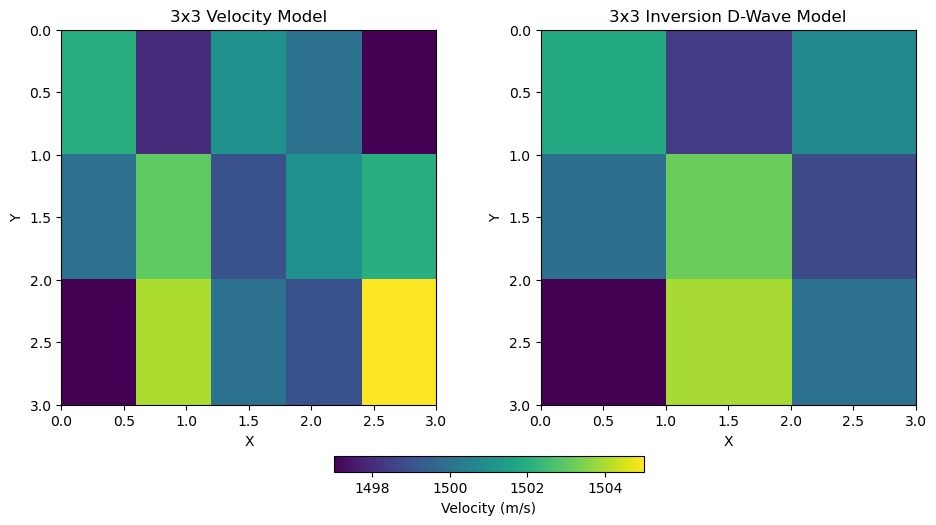

In [16]:
v_inversion_dwave = 1/np.loadtxt('results/s_9.txt')
v_inversion_dwave = v_inversion_dwave.reshape(3,3)

# Determine the common color scale
vmin = min(velocity_model.min(), v_inversion_dwave.min())
vmax = max(velocity_model.max(), v_inversion_dwave.max())

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot the first velocity model
im1 = axes[0].imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=[0, 3, 3, 0], origin='upper', vmin=vmin, vmax=vmax)
axes[0].set_title('3x3 Velocity Model')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Plot the second velocity model
im2 = axes[1].imshow(v_inversion_dwave, cmap='viridis', interpolation='nearest', extent=[0, 3, 3, 0], origin='upper', vmin=vmin, vmax=vmax)
axes[1].set_title('3x3 Inversion D-Wave Model')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Adjust the layout and add a colorbar below the subplots
fig.tight_layout(pad=3.0)
cbar = fig.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_label('Velocity (m/s)')

plt.show()

In [17]:
import glob
# Path to the directory containing the text files
file_path = "results/s_*.txt"  # Adjust this path to your directory

# Get a list of all files
file_list = glob.glob(file_path)
file_list = sorted(glob.glob(file_path))

file = file_list[0]
data = 1/np.loadtxt(file)
data = data.reshape(3,3)
diff = np.abs(data - velocity_model)

vmin = diff.min()
vmax = diff.max()

for i, file in enumerate(file_list):
    data = 1/np.loadtxt(file)
    data = data.reshape(3,3)
    diff = np.abs(data - velocity_model)

    vmin_tmp = diff.min()
    vmax_tmp = diff.max()
    if vmin_tmp < vmin:
        vmin = vmin_tmp
    if vmax_tmp > vmax:
        vmax = vmax_tmp


ValueError: operands could not be broadcast together with shapes (3,3) (3,5) 

ValueError: operands could not be broadcast together with shapes (3,3) (3,5) 

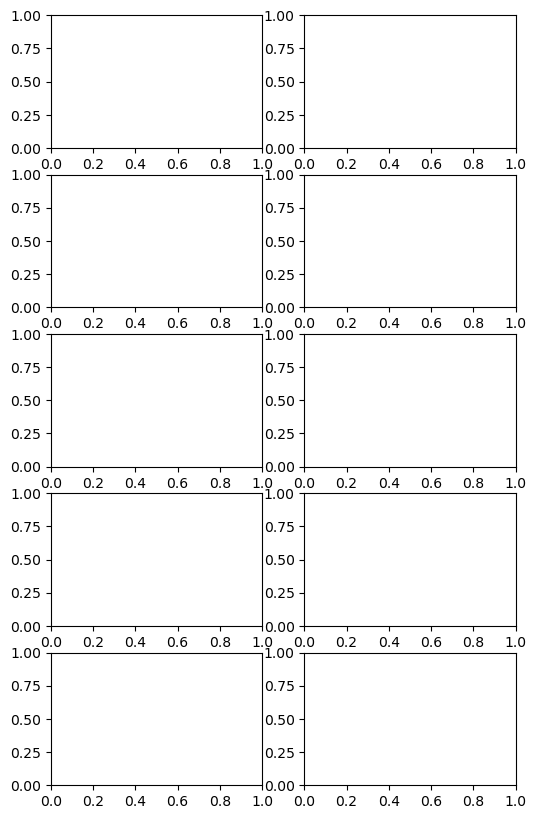

In [14]:
import glob
# Path to the directory containing the text files
file_path = "results/s_*.txt"  # Adjust this path to your directory

# Get a list of all files
file_list = glob.glob(file_path)
file_list = sorted(glob.glob(file_path))


# Determine the layout for the subplots
num_files = len(file_list)
cols = 2  # Number of columns
rows = 5  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(6, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each file and plot
for i, file in enumerate(file_list):
    # Load the data
    data = 1/np.loadtxt(file)
    data = data.reshape(3,3)
    
    diff = np.abs(data - velocity_model)

    # Plot the data
    im = axes[i].imshow(diff, cmap='jet', interpolation='nearest', origin='upper', extent=[0, 3, 3, 0], vmin=vmin, vmax=vmax)
    axes[i].set_title(f"Velocity Model {i}")
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')

# Adjust the layout and add a colorbar
fig.tight_layout()
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.016, pad=0.1)
cbar.set_label('Velocity (m/s)')

plt.show()

In [49]:
file_list

['results/s_8.txt',
 'results/s_9.txt',
 'results/s_4.txt',
 'results/s_5.txt',
 'results/s_7.txt',
 'results/s_6.txt',
 'results/s_2.txt',
 'results/s_3.txt',
 'results/s_1.txt',
 'results/s_0.txt']